## Load all required packages

In [2]:
# pip install clean-text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
from sklearn import mixture
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
from dlutils import dlutils

## Define preprocess function and PVTM class

In [3]:
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
def preprocess(texts, **kwargs):
    import string
    from dlutils import dlutils
    translator=str.maketrans('','',string.punctuation)
    texts = [text.translate(translator) for text in texts]
    texts= [clean(x,  **kwargs) for x in texts]
    return texts


In [7]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
class Documents(object):
    """
    """
    
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words=doc, tags=[i])
            
# x_docs = Documents(cleaned_texts)

model = Doc2Vec(vector_size=100,
                dbow_words=1,
                dm=0,
                epochs=1,
                window=5,
                seed=123,
                min_count=5,
                workers=6,
                alpha=0.025,
                min_alpha=0.025)

C:\Users\Viktoria\Anaconda3\envs\pvtm\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [250]:
class PVTM(Documents):
    def __init__(self,texts,**kwargs):        
        x = [kk.split() for kk in texts]
        Documents.__init__(self,x)
        self.x_docs = Documents(x)
        self.model = Doc2Vec(**kwargs)
    def gmm_clustering(self, **kwargs):
        self.gmm = mixture.GaussianMixture(**kwargs)
    def get_gmm_cluster_center(self,vectors, gmm):
        self.gmm_clustercenter = []
        assignments = gmm.predict(vectors)
        n_components = np.unique(assignments).shape[0]
        for i in range(n_components):
            gmm_centerindexe = np.where(assignments==i, True, False)
        
            self.gmm_clustercenter.append(vectors[gmm_centerindexe].mean(0))
    def get_gmm_cluster_center_probas(self,vectors, gmm):
        self.gmm_clustercenter_probas = []
    
        assignments_proba = gmm.predict_proba(vectors)
        n_components = assignments_proba.shape[1] 
        for i in range(n_components):
            center = []
            for j in range(len(vectors)):
                center_j = vectors[j]*assignments_proba[:,i][j]
                center.append(center_j)
            self.gmm_clustercenter_probas.append(np.mean(center,axis=0))
    def create_wordcloud(self,topic, center_probas, n_words):
        sims = cosine_similarity([center_probas[topic]], self.model.wv.vectors)
        sims = np.argsort(sims)[0][::-1]
        text = [self.model.wv.index2word[k] for k in sims[:n_words]]
        text = ', '.join(text)
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

## Load data

In [260]:
import os
input_dir_raw = 'data/heise/'
input_file = os.path.join(os.path.abspath(input_dir_raw), 'heise.txt')
print(input_file)
with open(input_file, 'r', encoding='utf-8') as file:
    #line for line in file:
    _input = file.readlines()

C:\Users\Viktoria\Desktop\Github\pvtm\data\heise\heise.txt


In [261]:
example_len = 10
texts = _input[:example_len]
cleaned_texts = preprocess(texts,lower=True,no_line_breaks=True,
                  no_currency_symbols = True, 
                  no_urls=True,no_emails=True, no_phone_numbers=True,
                  no_numbers=True,no_digits=False,
                  replace_with_url="",
                  replace_with_email="",
                  replace_with_phone_number="",
                  replace_with_number="",
                  replace_with_currency_symbol="",
                  replace_with_digit="", 
                  lang='en')

In [263]:
_input = cleaned_texts
_input, vocab = dlutils.popularity_based_prefiltering(_input, min_df = 0.05, max_df = 0.5, stopwords = stop_words)

0.05 0.5
2459 words in the vocabulary


## Create PVTM object

In [264]:
pvtm = PVTM(_input, vector_size=100,
                dbow_words=1,
                dm=0,
                epochs=1,
                window=5,
                seed=123,
                min_count=1, # set to 1 just to test
                workers=6,
                alpha=0.025,
                min_alpha=0.025)

C:\Users\Viktoria\Anaconda3\envs\pvtm\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [265]:
# Train the model
print('Building vocab')
pvtm.model.build_vocab(pvtm.x_docs)
doc_counts = len(pvtm.documents)
for epoch in range(1):
    print("epoch " + str(epoch))
    pvtm.model.train(pvtm.x_docs, total_examples=doc_counts, epochs=1)
    #     model.save(MODEL_SAVE_NAME)
    pvtm.model.alpha -= 0.002  # decrease the learning rate
    pvtm.model.min_alpha = model.alpha  # fix the learning rate, no decay

Building vocab
epoch 0


In [266]:
# store the DocVecs to tsv
vectors = np.array(pvtm.model.docvecs.vectors_docs)
# Detect the language of the documents and load the respective stopwords
vocab = list(pvtm.model.wv.vocab.keys())

In [267]:
len(vectors)
len(vocab)

10

2379

In [268]:
n_topics=5
pvtm.gmm_clustering(n_components=n_topics,
                              covariance_type='tied',
                              verbose=1,
                              n_init=1)

In [269]:
pvtm.gmm.fit(vectors)
print('BIC: {}'.format(pvtm.gmm.bic(vectors)))

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

BIC: 1130.5830267879155


In [270]:
pvtm.get_gmm_cluster_center(vectors, pvtm.gmm)
pvtm.get_gmm_cluster_center_probas(vectors, pvtm.gmm)

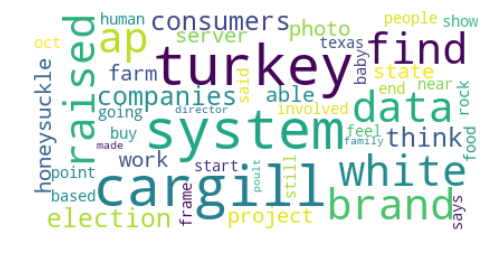

In [275]:
pvtm.create_wordcloud(3, pvtm.gmm_clustercenter_probas,50)